# Friends Classification Text (xgB) - 1

This is classification of dialogue in FRIENDS TV Series.

<!-- https://stackoverflow.com/questions/61000500/tensorflow-keras-bert-multiclass-text-classification-accuracy -->

In [1]:
import pandas as pd
import re
import numpy as np
import time

import os
import pprint
import tensorflow as tf

import sys
sys.path.insert(1, '../../src/all_functions/')

from text_tools import *

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             roc_auc_score)
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization
import joblib
from sklearn.model_selection import cross_validate
from sklearn import metrics

In [2]:
# help(drive.mount)

In [3]:
# PATH_DATA = 'gdrive/'
PATH_DATA = '../../data/'

## Importing Data

In [4]:
df_dlg_seen = pd.read_csv(PATH_DATA+'friends_seen_season_1.csv')
df_dlg_unseen = pd.read_csv(PATH_DATA+'friends_unseen_season_1.csv')

In [5]:
df_dlg_seen['text'] = df_dlg_seen['dialogue5']
df_dlg_unseen['text'] = df_dlg_unseen['dialogue5']

In [6]:
df_dlg_unseen.head()

,eps,dialogue_ids,scenes_places,label_place,label_str,label,season,dialogue,dialogue5,len_dialogue5,is_null2,ids,text
0,0901,0,[rachel's room],2,rachel,1,9,joey. (he turns to face rachel on one knee w...,joey,1,False,49643,joey
1,0901,1,[rachel's room],2,rachel,1,9,(seeing the ring) oh my god. (pause) okay. (...,my god,2,False,49644,my god
2,0901,2,[rachel's room],2,rachel,1,9,so uh...i guess we should...make it official...,so uh i guess we should make it official huh,10,False,49645,so uh i guess we should make it official huh
3,0901,3,[rachel's room],2,joey,5,9,uh... look rach...(ross enters.) hey ross is...,uh look rach hey ross is here hey look it's my...,16,False,49646,uh look rach hey ross is here hey look it's my...
4,0901,4,[rachel's room],2,ross,2,9,hey joey. (to rachel) hey you.,joey you,2,False,49647,joey you


In [7]:
data_train = df_dlg_seen[(df_dlg_seen.is_train == True)&(df_dlg_seen.label!=0)][['text','label']]
data_train['label'] = data_train['label']-1
data_test = df_dlg_seen[(df_dlg_seen.is_train == False)&(df_dlg_seen.label!=0)][['text','label']]
data_test['label'] = data_test['label']-1
data_unseen = df_dlg_unseen[(df_dlg_unseen.label!=0)][['text','label']]
data_unseen['label'] = data_unseen['label']-1

In [8]:
data_train.shape

(28347, 2)

In [9]:
data_test.shape

(9437, 2)

In [10]:
data_unseen.shape

(9085, 2)

In [11]:
XX = data_test.label.value_counts()
XX/XX.sum()

1    0.179612
0    0.177811
3    0.167532
2    0.166049
4    0.160750
5    0.148246
Name: label, dtype: float64

## Tokenizer - TFIDF

In [12]:
MAX_LEN = 100
EMBED_SIZE = 128

In [13]:
OH = OneHotEncoder()

In [14]:
data_train.head()

,text,label
0,there's nothing to tell he's just some guy i w...,2
2,all right joey be nice so does he have a hump ...,3
4,just because i don't want her to go through wh...,5
5,okay everybody relax this is not even a date i...,2
6,sounds like a date to me,3


In [15]:
data_test.head()

,text,label
1,c'mon you're going out with the guy there's go...,4
3,wait does he eat chalk,5
9,then i look down and i realize there's a phone...,3
11,that's,3
14,all of a sudden the phone starts to ring now i...,3


In [16]:
df_dlg_unseen.head()

,eps,dialogue_ids,scenes_places,label_place,label_str,label,season,dialogue,dialogue5,len_dialogue5,is_null2,ids,text
0,0901,0,[rachel's room],2,rachel,1,9,joey. (he turns to face rachel on one knee w...,joey,1,False,49643,joey
1,0901,1,[rachel's room],2,rachel,1,9,(seeing the ring) oh my god. (pause) okay. (...,my god,2,False,49644,my god
2,0901,2,[rachel's room],2,rachel,1,9,so uh...i guess we should...make it official...,so uh i guess we should make it official huh,10,False,49645,so uh i guess we should make it official huh
3,0901,3,[rachel's room],2,joey,5,9,uh... look rach...(ross enters.) hey ross is...,uh look rach hey ross is here hey look it's my...,16,False,49646,uh look rach hey ross is here hey look it's my...
4,0901,4,[rachel's room],2,ross,2,9,hey joey. (to rachel) hey you.,joey you,2,False,49647,joey you


In [17]:
corpus = data_train['text'].tolist()+data_test['text'].tolist()
vectorizer = TfidfVectorizer(min_df = 0.05, max_features = MAX_LEN)
vectorizer.fit(corpus)

TfidfVectorizer(max_features=100, min_df=0.05)

In [18]:
def get_input(df):
    txt = df['text']
    X = vectorizer.transform(txt)
    label = df['label']
    return X.toarray(),label.values

In [19]:
# for txt,label in data_train.values:
#     text_encode = encode(txt)
#     text_encode = set_fix_length(text_encode,max_len = MAX_LEN)
#     X_train.append(text_encode)
#     label_train.append(label)
    
X_train,label_train = get_input(pd.concat([data_train,data_test]))
X_unseen,label_unseen = get_input(data_unseen)

In [20]:
OH.fit(label_train.reshape(len(label_train),-1))

OneHotEncoder()

In [21]:
y_train = OH.transform(label_train.reshape(len(label_train),-1)).toarray()
# y_test = OH.transform(label_test.reshape(len(label_test),-1)).toarray()
y_unseen = OH.transform(label_unseen.reshape(len(label_unseen),-1)).toarray()

In [22]:
label_train

array([2, 3, 5, ..., 0, 4, 0])

## Training Model

In [23]:
def xgb_evaluate(max_depth,learning_rate,n_estimators,
                 gamma, reg_alpha,reg_lambda,X=X_train,y=label_train):

    md= int(max_depth)
    lr= max(learning_rate,0)
    ne= int(n_estimators)
    gamma= max(gamma, 0) # 0
    ra= max(reg_alpha, 0) # 0
    rl= max(reg_lambda, 0) # 1
    see= 123
    
    xgB=XGBClassifier(max_depth=md,learning_rate=lr,
                 n_estimators=ne,gamma=gamma,reg_alpha=ra,
                 reg_lambda=rl,seed=see, 
                 nthread=2,num_classes=6)
    cv_results = cross_validate(xgB, X, y, cv=5, scoring='f1_macro', n_jobs= 2)
    return cv_results['test_score'].mean()

In [24]:
xgbBO = BayesianOptimization(xgb_evaluate, 
                {'max_depth': (10,15),'learning_rate': (0.1, 0.35),
                    'n_estimators': (10,17),'gamma': (1, 3.5),'reg_alpha': (1, 2),
                    'reg_lambda': (1, 2)})

In [25]:
xgbBO.maximize(init_points=10, n_iter=5)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------
|  1        |  0.1992   |  3.126    |  0.2675   |  14.25    |  15.53    |  1.485    |  1.847    |
|  2        |  0.1971   |  1.643    |  0.1415   |  11.03    |  14.69    |  1.599    |  1.684    |
|  3        |  0.1978   |  3.474    |  0.2603   |  10.18    |  15.42    |  1.006    |  1.773    |
|  4        |  0.1964   |  3.121    |  0.1649   |  10.11    |  13.3     |  1.354    |  1.487    |
|  5        |  0.1994   |  2.486    |  0.2882   |  14.43    |  15.48    |  1.648    |  1.916    |
|  6        |  0.1976   |  3.329    |  0.2968   |  13.5     |  12.95    |  1.856    |  1.102    |
|  7        |  0.1974   |  2.922    |  0.1496   |  12.62    |  13.05    |  1.193    |  1.245    |
|  8        |  0.199    |  2.228    |  0.3096   |  14.51    |  13.21    |  1.27     |  1.209    |
|  9        |  0.196

In [26]:
# |  18       |  0.2054   |  1.885    |  0.1672   |  14.55    |  10.49    |  2.814    |  0.9857   |
# |  2        |  0.2009   |  1.003    |  0.3106   |  12.55    |  16.46    |  0.9007   |  0.8912   |

# |  14       |  0.2011   |  2.0      |  0.3239   |  14.11    |  15.53    |  1.5      |  1.57     |

In [27]:
par = xgbBO.max['params']
par

{'gamma': 2.694825338975148,
 'learning_rate': 0.35,
 'max_depth': 13.342879009768374,
 'n_estimators': 16.778136859953854,
 'reg_alpha': 2.0,
 'reg_lambda': 2.0}

In [28]:
par['max_depth'] = int(par['max_depth'])
par['n_estimators'] = int(par['n_estimators'])

In [29]:
xgB0=XGBClassifier(**par)
xgB0.fit(X_train,label_train)

/Users/alamhanz/anaconda/envs/p37/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:01:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=2.694825338975148,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.35, max_delta_step=0, max_depth=13,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=16, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=2.0,
              reg_lambda=2.0, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Testing

In [30]:
data_unseen

,text,label
0,joey,0
1,my god,0
2,so uh i guess we should make it official huh,0
3,uh look rach hey ross is here hey look it's my...,4
4,joey you,1
...,...,...
11030,oh it's gonna be okay,3
11031,do you guys have to go to the new house right ...,0
11032,we got some time,2
11033,okay should we get some coffee,0


In [31]:
y_pred_label = xgB0.predict(X_unseen)
# y_pred_label = np.argmax(y_pred,axis = 1)
y_true_label = data_unseen['label'].values

              precision    recall  f1-score   support

           0       0.24      0.28      0.26      1545
           1       0.18      0.29      0.23      1649
           2       0.21      0.25      0.23      1487
           3       0.21      0.18      0.19      1521
           4       0.22      0.12      0.16      1491
           5       0.20      0.10      0.13      1392

    accuracy                           0.21      9085
   macro avg       0.21      0.20      0.20      9085
weighted avg       0.21      0.21      0.20      9085



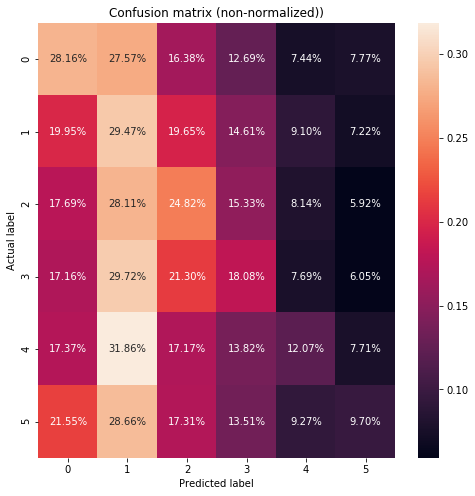

In [32]:
report = classification_report(y_true_label, y_pred_label)
print(report)


def plot_cm(labels, predictions, p=0.5):
#     cm = confusion_matrix(labels, predictions)
#     plt.figure(figsize=(5, 5))
#     sns.heatmap(cm, annot=True, fmt="d")
    cm = confusion_matrix(labels, predictions)
    cm = (cm.transpose()/cm.sum(axis = 1)).transpose()
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt=".2%")
    plt.title("Confusion matrix (non-normalized))")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")


plot_cm(y_true_label, y_pred_label)